# Reddit API Call for Huawei

In [ ]:
from api_funcs import *

In [ ]:
posts = subreddit_posts('Huawei', 1000)

In [ ]:
posts

In [ ]:
posts.to_csv('Posts.csv',index=False)

In [ ]:
replies = replies_to_posts(posts)

In [ ]:
replies

In [ ]:
replies.to_csv('Replies.csv',index=False)

# Data Cleaning and Exploration

In [1]:
import re

import pandas as pd
import nltk

In [2]:
replies = pd.read_csv('Replies.csv')

### Remove links, \n, \t...., empty strings

In [3]:
sample = replies['Reply'][7]
sample

'I got Google mobile services to work on my P40 Pro using this tutorial - https://youtu.be/8sfJVGqM_5Q'

In [4]:
sample2 = replies['Reply'][5]
sample2

'Google Drive - pCloud\nGmail - move to ProtonMail or Tutanota,\nGoogle Maps - OsmAnd'

In [5]:
replies.Reply = replies.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
replies.Reply = replies.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [6]:
nan_value = float("NaN")
replies.replace("", nan_value, inplace=True)
replies.dropna(subset=['Reply'], inplace=True)

Links need to be removed as they don't add any information that is useful. 

New line characters and other similar ones should also need to be removed as they join two words together, making them indistinguishable from each other and causing us to miss important information. 

Empty strings were also removed as they don't add value to data exploration/sentiment analysis.

### Bigrams

In [7]:
all_text = replies.iloc[:].Reply.str.cat(sep='. ')

In [8]:
all_text = nltk.word_tokenize(all_text)

In [9]:
from nltk.collocations import *

def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

In [10]:
print(common_bigrams(all_text, 10, 20))

[('third', 'party'), ('Petal', 'Search'), ('nova', '5t'), ('gon', 'na'), ('#', 'x200B'), ('factory', 'reset'), ('Introducing', '/r/Honor'), ('Start', 'discussions'), ('Post', 'News'), ('x200B', ';'), ('performed', 'automatically'), ('App', 'Gallery'), ('official', 'giveaways'), ('Harmony', 'OS'), ('open', 'source'), ('100', '%'), ('power', 'button'), ('Feel', 'free'), ('Play', 'Store'), ('&', '#')]


The first bigram displayed is third party which most likely refers to how Huawei users need another method other than Play Store to download third party apps such as Facebook, Instagram etc.

The second bigram displayed is Petal Search, a new feature on Huawei phones which is essentially a replacement of Google due to the ban on Huawei from using Google services. 

Another related bigram is Harmony OS which is Huawei's own operating system which Huawei plans to replace their phones with instead of using Android in case they are also banned from it as well and as a response to the Google ban.

Play Store is also a bigram that most likely refers to the Google ban, and its implications on Huawei phones.

Interestingly, only one model of a Huawei phone is displayed (which is nova 5t). It seems more likely that the flagships of Huawei (P series) would be talked about more.

### Wordcloud

In [11]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = replies.iloc[:].Reply.str.cat(sep='. ')

In [12]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

Add 'Huawei' to the stopwords as it is obvious that we are talking about Huawei and does not add additional insight.

Also added other words that I thought weren't very insightful and wouldn't really contribute much.

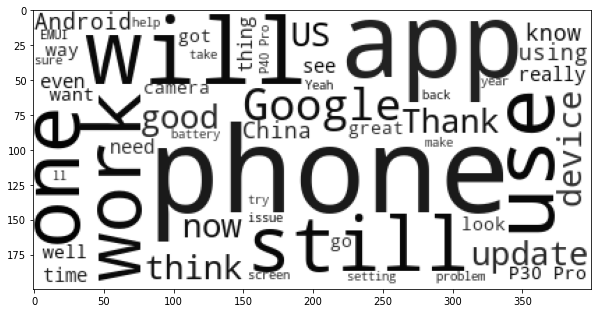

In [13]:
stp = STOPWORDS.copy()
stp.add('Huawei')
stp.add("n't")
stp.add('ca')
stp.add('re')
stp.add('ve')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

Interestingly, Harmony OS or Petal search aren't found in the wordcloud despite them being found in the bigrams. I would have thought it would be common topics considering recent events about Huawei.

US is in the wordcloud which most likely refers to the tensions between China and US.

Google and Android are fairly common words, whether this refers to the recent Google ban or is just issues people may be having is not clear though.

# Vader

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

In [15]:
df = replies
df

,Reply,Upvote,Time,Key
0,* * \ [ MicroG Services\ ] GMS for all Huawei ...,1.0,2020-08-13 15:10:37,0.0
1,Google Chrome -- -- > Firefox Focus,11.0,2020-05-29 01:47:12,0.0
2,I use yandex disk in Belarus . Unlimited stora...,8.0,2020-06-01 09:08:23,0.0
3,Waze works without Google Play services ?,5.0,2020-05-29 08:39:25,0.0
4,6. you and add a webapp of you tube my using y...,6.0,2020-05-29 00:40:56,0.0
...,...,...,...,...
3313,"I do n't have ChromeCast , and I 'm the sole u...",1.0,2020-08-21 02:05:25,950.0
3314,That 's odd . Also no Android TV on the networ...,1.0,2020-08-21 02:36:31,950.0
3315,"Nah , my phone is the only smart thing in the ...",1.0,2020-08-21 02:43:44,950.0
3316,Anyone ?,1.0,2020-08-16 20:28:06,951.0


Extra data cleaning (empty strings)

In [16]:
df[['neg','neu','pos','compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

Adding a column that says whether the reply is neutral, positive or negative based on compound for easier readability.

I also adjusted what constitutes as positive as there were a few positive scores that were very low (between 0 and 0.2) which were most likely neutral sentiments rather than a positve one.

In [17]:
def label_compound_result(row):
    if row['compound'] > 0.2:
        return 'positive'
    elif row['compound'] < 0:
        return 'negative'
    return 'neutral'

In [18]:
df['compound_result'] = df.apply (lambda row: label_compound_result(row), axis=1)

In [19]:
df

,Reply,Upvote,Time,Key,neg,neu,pos,compound,compound_result
0,* * \ [ MicroG Services\ ] GMS for all Huawei ...,1.0,2020-08-13 15:10:37,0.0,0.000,1.000,0.000,0.0000,neutral
1,Google Chrome -- -- > Firefox Focus,11.0,2020-05-29 01:47:12,0.0,0.000,1.000,0.000,0.0000,neutral
2,I use yandex disk in Belarus . Unlimited stora...,8.0,2020-06-01 09:08:23,0.0,0.052,0.665,0.283,0.8655,positive
3,Waze works without Google Play services ?,5.0,2020-05-29 08:39:25,0.0,0.289,0.711,0.000,-0.2584,negative
4,6. you and add a webapp of you tube my using y...,6.0,2020-05-29 00:40:56,0.0,0.000,0.893,0.107,0.4588,positive
...,...,...,...,...,...,...,...,...,...
3313,"I do n't have ChromeCast , and I 'm the sole u...",1.0,2020-08-21 02:05:25,950.0,0.000,1.000,0.000,0.0000,neutral
3314,That 's odd . Also no Android TV on the networ...,1.0,2020-08-21 02:36:31,950.0,0.243,0.757,0.000,-0.5423,negative
3315,"Nah , my phone is the only smart thing in the ...",1.0,2020-08-21 02:43:44,950.0,0.074,0.736,0.190,0.7717,positive
3316,Anyone ?,1.0,2020-08-16 20:28:06,951.0,0.000,1.000,0.000,0.0000,neutral


In [20]:
replies.to_csv('Replies - Sentiment analysis.csv',index=False)

In [21]:
replies.compound_result.value_counts().positive

1612

In [22]:
replies.compound_result.value_counts().negative

673

In [23]:
replies.compound_result.value_counts().neutral

1020

Numbers for each sentiment:
    
    Positive: 1612
    
    Negative: 673
    
    Neutral: 1020